https://www.kaggle.com/code/kimberlym227/bird-classification-using-cnn-efficientnetb0

In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout

In [3]:
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model

In [4]:
from tensorflow.keras import preprocessing
# System libraries
from pathlib import Path
import os.path
import random
# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns

In [5]:
sns.set_style('darkgrid')
# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [6]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
# Import series of helper functions for our notebook
# import module we'll need to import our custom module
from shutil import copyfile


In [7]:
# import all our functions
from helper_functions import *

In [8]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [9]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [10]:
# Walk through each directory

dataset = "E:\Python code\鸟类识别_1"
walk_through_dir(dataset);

There are 1 directories and 0 images in 'E:\Python code\鸟类识别_1'.
There are 10 directories and 0 images in 'E:\Python code\鸟类识别_1\train'.
There are 0 directories and 163 images in 'E:\Python code\鸟类识别_1\train\ABBOTTS BABBLER'.
There are 0 directories and 180 images in 'E:\Python code\鸟类识别_1\train\ABBOTTS BOOBY'.
There are 0 directories and 179 images in 'E:\Python code\鸟类识别_1\train\ABYSSINIAN GROUND HORNBILL'.
There are 0 directories and 135 images in 'E:\Python code\鸟类识别_1\train\AFRICAN CROWNED CRANE'.
There are 0 directories and 154 images in 'E:\Python code\鸟类识别_1\train\AFRICAN EMERALD CUCKOO'.
There are 0 directories and 137 images in 'E:\Python code\鸟类识别_1\train\AFRICAN FIREFINCH'.
There are 0 directories and 155 images in 'E:\Python code\鸟类识别_1\train\AFRICAN OYSTER CATCHER'.
There are 0 directories and 187 images in 'E:\Python code\鸟类识别_1\train\AFRICAN PIED HORNBILL'.
There are 0 directories and 179 images in 'E:\Python code\鸟类识别_1\train\AFRICAN PYGMY GOOSE'.
There are 0 directori

In [11]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Kimberly's edit:¶
I edited the below cell to include the top 10 labels from the dataset as it was set for 20 and there are fewer than 20 categories available in my dataset.

In [12]:
# Get the dataset labels
label_counts = image_df['Label'].value_counts()[:10]
label_counts

Label
AFRICAN PIED HORNBILL         374
ABBOTTS BOOBY                 360
ABYSSINIAN GROUND HORNBILL    358
AFRICAN PYGMY GOOSE           358
ABBOTTS BABBLER               326
AFRICAN OYSTER CATCHER        310
AFRICAN EMERALD CUCKOO        308
AFRICAN FIREFINCH             274
AFRICAN CROWNED CRANE         270
ALBATROSS                     264
Name: count, dtype: int64

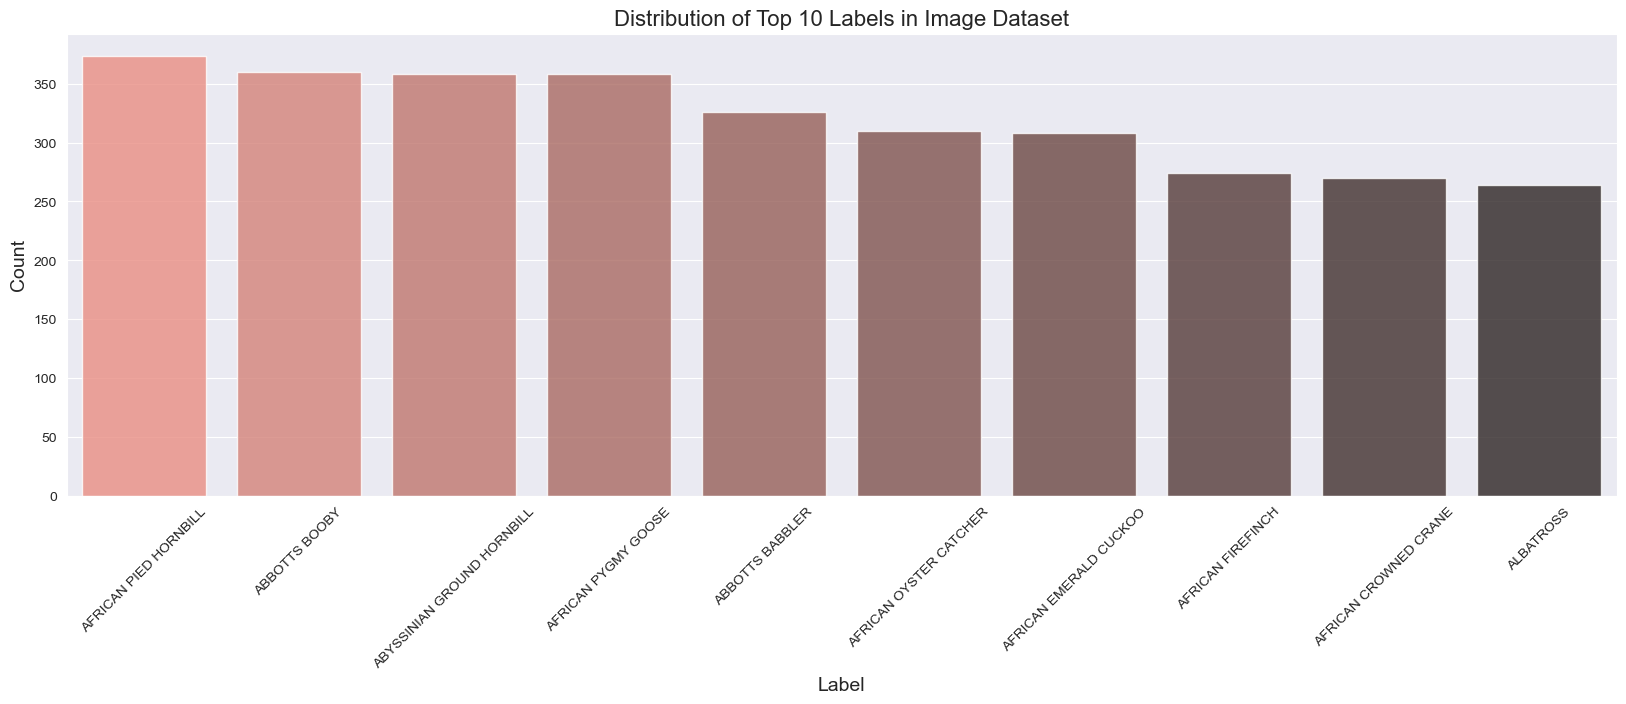

In [13]:
plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')
plt.title('Distribution of Top 10 Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

# Kimberly's edit:¶
The above plot shows the imbalance of the data in my dataset. There are fewer images available for the categories I collated manually than there are in the categories taken from the Gpiosenka "BIRDS 525 SPECIES - IMAGE CLASSIFICATION" dataset. This is not desirable as it could lead to bias in the classifications provided by the model as there would be more training material and therefore greater leaning towards some categories more than others. However, there was insufficient time to seek out more images from other sources and these were the only suitable images available in the free-to-use section of Pixabay.

🔭Visualizing images from the dataset

# Kimberly's edit:¶
The below cell displays 16 random images from the dataset in use.

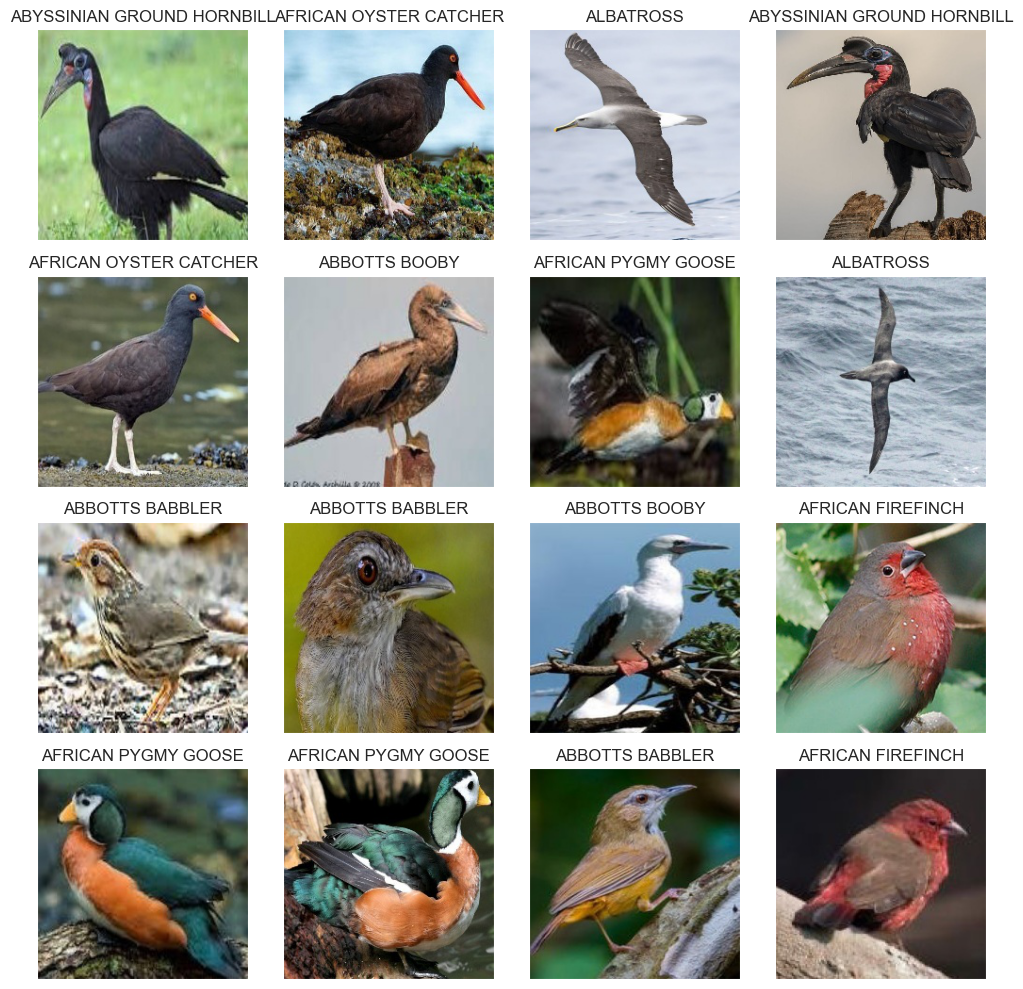

In [14]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [15]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

# Kimberly's edit:¶
Again, the following cell was amended to include the path to a sample of image data from a file within my dataset.

In [57]:
# View random sample from the dataset
#p = random_sample(r'E:\Python code\鸟类识别_1\train\ABBOTTS BABBLER')
p = random_sample(r"E:\Python code\鸟类识别_1\train\ABBOTTS BABBLER")

In [58]:
p

'E:/Python code/鸟类识别_1/train/ABBOTTS BABBLER/123.jpg'

In [45]:
orig = cv2.imread(p)

In [47]:
path = r"E:\Python code\鸟类识别_1\train\ABBOTTS BABBLER"

In [48]:
items = Path(path).glob(f'*')

In [49]:
items

<generator object Path.glob at 0x0000018ED2E96460>

In [50]:
items = list(items)
items

[WindowsPath('E:/Python code/鸟类识别_1/train/ABBOTTS BABBLER/001.jpg'),
 WindowsPath('E:/Python code/鸟类识别_1/train/ABBOTTS BABBLER/002.jpg'),
 WindowsPath('E:/Python code/鸟类识别_1/train/ABBOTTS BABBLER/003.jpg'),
 WindowsPath('E:/Python code/鸟类识别_1/train/ABBOTTS BABBLER/004.jpg'),
 WindowsPath('E:/Python code/鸟类识别_1/train/ABBOTTS BABBLER/005.jpg'),
 WindowsPath('E:/Python code/鸟类识别_1/train/ABBOTTS BABBLER/006.jpg'),
 WindowsPath('E:/Python code/鸟类识别_1/train/ABBOTTS BABBLER/007.jpg'),
 WindowsPath('E:/Python code/鸟类识别_1/train/ABBOTTS BABBLER/008.jpg'),
 WindowsPath('E:/Python code/鸟类识别_1/train/ABBOTTS BABBLER/009.jpg'),
 WindowsPath('E:/Python code/鸟类识别_1/train/ABBOTTS BABBLER/010.jpg'),
 WindowsPath('E:/Python code/鸟类识别_1/train/ABBOTTS BABBLER/011.jpg'),
 WindowsPath('E:/Python code/鸟类识别_1/train/ABBOTTS BABBLER/012.jpg'),
 WindowsPath('E:/Python code/鸟类识别_1/train/ABBOTTS BABBLER/013.jpg'),
 WindowsPath('E:/Python code/鸟类识别_1/train/ABBOTTS BABBLER/014.jpg'),
 WindowsPath('E:/Python code/鸟类识别_

In [51]:
p = random.choice(items)
p 

WindowsPath('E:/Python code/鸟类识别_1/train/ABBOTTS BABBLER/083.jpg')

In [52]:
p.as_posix()

'E:/Python code/鸟类识别_1/train/ABBOTTS BABBLER/083.jpg'

In [53]:
orig = cv2.imread(p)

In [54]:
orig

In [55]:
orig

In [56]:
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [34]:
p = random_sample(r'E:\Python code\鸟类识别_1\train\ABBOTTS BABBLER',extension=1)
p

IndexError: Cannot choose from an empty sequence

In [59]:
# View random sample from the dataset
p = random_sample(r'E:\Python code\鸟类识别_1\train\ABBOTTS BABBLER')

orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [20]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [17]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [18]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [19]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 2049 validated image filenames belonging to 10 classes.
Found 512 validated image filenames belonging to 10 classes.
Found 641 validated image filenames belonging to 10 classes.


In [20]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'experimental'